In [2]:
import pandas as pd

path = "./archive/stemmed_cleaned_data.csv"

df = pd.read_csv(path, delimiter=",", quotechar='"')

print(df.head())

                              title  \
0               Mental Note Vol. 24   
1         Your Brain On Coronavirus   
2                    Mind Your Nose   
3          The 4 Purposes of Dreams   
4  Surviving a Rod Through the Head   

                                                text  \
0  Photo by Josh Riemer on Unsplash\n\nMerry Chri...   
1  Your Brain On Coronavirus\n\nA guide to the cu...   
2  Mind Your Nose\n\nHow smell training can chang...   
3  Passionate about the synergy between science a...   
4  You’ve heard of him, haven’t you? Phineas Gage...   

                                                 url                 authors  \
0  https://medium.com/invisible-illness/mental-no...            ['Ryan Fan']   
1  https://medium.com/age-of-awareness/how-the-pa...       ['Simon Spichak']   
2  https://medium.com/neodotlife/mind-your-nose-f...                      []   
3  https://medium.com/science-for-real/the-4-purp...  ['Eshan Samaranayake']   
4  https://medium.com/live-y

In [3]:
import numpy as np
import nltk
import ast
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

tags = [
    "Blockchain", "Data Science", "Technology", "Programming", "Poetry",
    "Cryptocurrency", "Machine Learning", "Life", "Bitcoin", "Writing",
    "Politics", "Startup", "Life Lessons", "Self Improvement", "Covid 19",
    "Software Development", "Love", "Python", "Business", "Health",
    "Mental Health", "JavaScript", "Relationships", "Education",
    "Artificial Intelligence", "Culture", "Design", "Self", "Marketing",
    "Entrepreneurship", "Ethereum", "Music", "Productivity",
    "Web Development", "History", "Humor", "Data Visualization",
    "Leadership", "Social Media", "Psychology", "Travel", "Fiction",
    "Creativity", "Coronavirus", "Parenting", "Crypto", "Science",
    "Tech", "UX", "Short Story"
]

# Liste des 20 premiers tags
top_20_tags = tags[:20].copy()

#On ne garde que les article qui possent un des 20 tags séléctionnés

df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Filtrer le DataFrame pour ne garder que les articles avec ces tags
df_filtered = df[df['tags'].apply(lambda tags: any(tag in top_20_tags for tag in tags))].copy()

# On ne garde que le premier tag pour chaque article
df_filtered['main_tag'] = df_filtered['tags'].apply(lambda tags: next((tag for tag in tags if tag in top_20_tags), None))

# Supprime les lignes avec clean_text vide
df_filtered = df_filtered.dropna(subset=['clean_text'])  

print(df_filtered)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\scien\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\scien\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\scien\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                    title  \
0                                     Mental Note Vol. 24   
3                                The 4 Purposes of Dreams   
4                        Surviving a Rod Through the Head   
5       Mentally, Young Adults Are Suffering Most From...   
6       How to Turn Your Popular Blog Series Into a Be...   
...                                                   ...   
192333  [Live Stream] 2021 Soul Train Music Awards | F...   
192336  The global startup festival “COMEUP 2021” begi...   
192340  How To Deal with Loneliness in Festivals & Exp...   
192342                        Type 2 Diabetes on the Rise   
192343  The Concept of Stem Cells. Have you ever wonde...   

                                                     text  \
0       Photo by Josh Riemer on Unsplash\n\nMerry Chri...   
3       Passionate about the synergy between science a...   
4       You’ve heard of him, haven’t you? Phineas Gage...   
5       Mentally, Young

In [4]:
# Transformer les textes en nombres avec TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # On limite à 5000 mots les plus fréquents
X = vectorizer.fit_transform(df_filtered['clean_text'])  # Convertir les textes en matrices TF-IDF

# Transformer les tags en nombres
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_filtered['main_tag'])  # Transformer les catégories en nombres

In [3]:


# Appliquer un classifieur KNN avec la validation croisée

k_values = [5, 10, 20, 50, 100, 500, 1000]  # Différentes valeurs de k
scores = []  # Stocker les scores de chaque k

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Cross-validation (5 folds) et moyenne des scores
    score = np.mean(cross_val_score(knn, X, y, cv=5, scoring='accuracy'))
    scores.append(score)
    print(f"k={k}, précision moyenne={score:.4f}")

# Trouver la meilleure valeur de k
best_k = k_values[np.argmax(scores)]
best_score = max(scores)
print(f"\nMeilleur k = {best_k} avec une précision de {best_score:.4f}")



k=5, précision moyenne=0.2457
k=10, précision moyenne=0.2875
k=20, précision moyenne=0.4461
k=50, précision moyenne=0.4760
k=100, précision moyenne=0.4847
k=500, précision moyenne=0.4971
k=1000, précision moyenne=0.4917

Meilleur k = 500 avec une précision de 0.4971


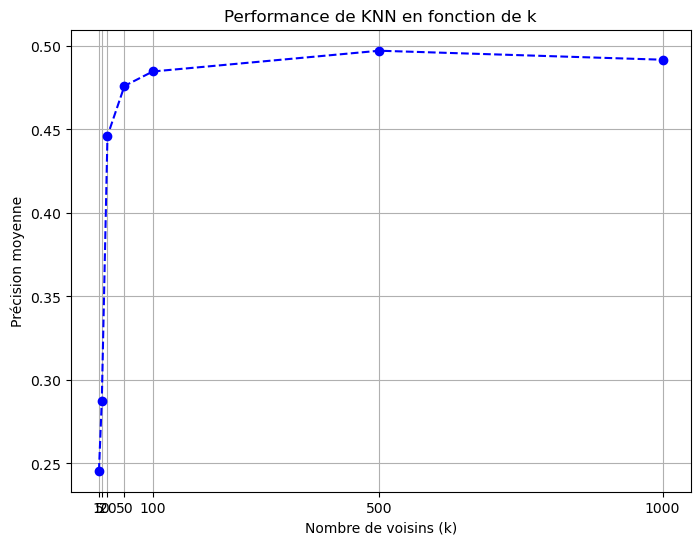

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(k_values, scores, marker='o', linestyle='dashed', color='b')
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Précision moyenne")
plt.title("Performance de KNN en fonction de k")
plt.xticks(k_values)
plt.grid()
plt.show()


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Meilleur modèle avec le meilleur k trouvé
knn_best = KNeighborsClassifier(n_neighbors=best_k)

# Séparer les données en train/test (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
knn_best.fit(X_train, y_train)

# Faire des prédictions
y_pred = knn_best.predict(X_test)


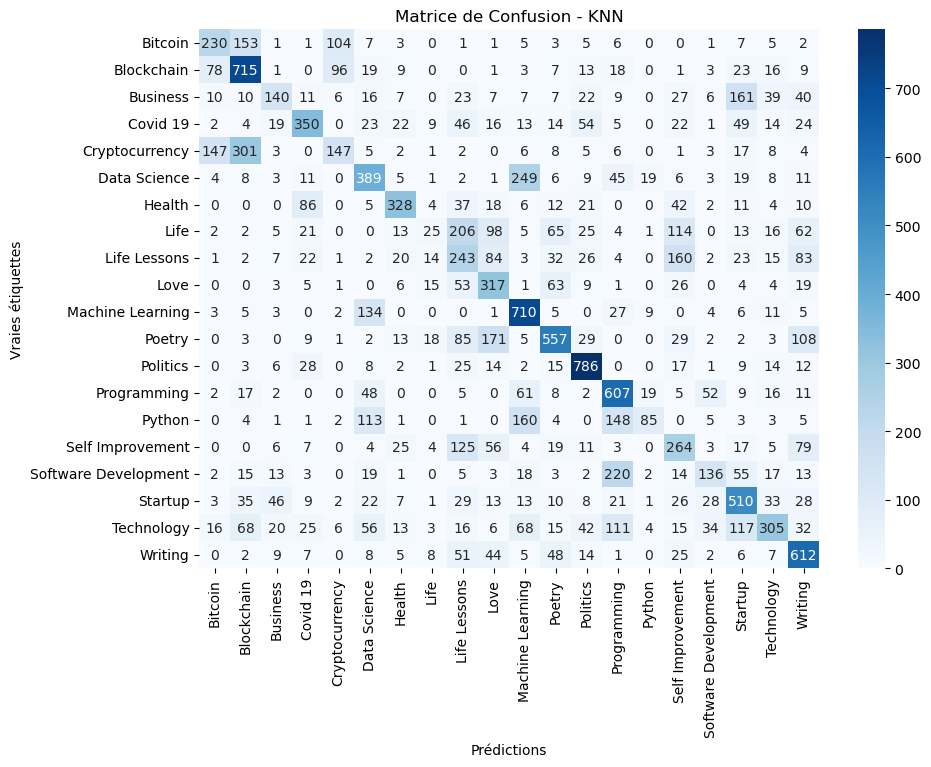

In [6]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Tracer la matrice avec Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de Confusion - KNN")
plt.xticks(rotation=90)
plt.show()


In [7]:
# Précision globale
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision globale : {accuracy:.4f}")

# Rapport de classification (Precision, Recall, F1-score par classe)
print("\nRapport de Classification :\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Précision globale : 0.4994

Rapport de Classification :

                      precision    recall  f1-score   support

             Bitcoin       0.46      0.43      0.44       535
          Blockchain       0.53      0.71      0.61      1012
            Business       0.49      0.26      0.33       548
            Covid 19       0.59      0.51      0.55       687
      Cryptocurrency       0.40      0.22      0.28       666
        Data Science       0.44      0.49      0.46       799
              Health       0.68      0.56      0.61       586
                Life       0.24      0.04      0.06       677
        Life Lessons       0.25      0.33      0.29       744
                Love       0.37      0.60      0.46       527
    Machine Learning       0.53      0.77      0.63       925
              Poetry       0.62      0.54      0.57      1037
            Politics       0.73      0.83      0.78       943
         Programming       0.49      0.70      0.58       864
            